# Time Series Clustering
### Clustering zipcodes based on economic development (businesses count) between 1993-2006

# Data

1- Download the census bureau business data for all years 1993-2014. 

You can investigate using the API or use these links:

https://www.census.gov/econ/geo-zip.html

https://www.census.gov//programs-surveys/cbp.html

https://www.census.gov/programs-surveys/cbp/data/datasets.html

The data is also on the github [repo](https://github.com/fedhere/PUI2018_fb55/tree/master/HW12_fb55). Each file is the economic census for 1 year. 

2- Download the NYC zipcodes shapefile. 

https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u

https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## Census bureau: County Business Patterns / Record layouts
### We are interessted in EST: Total Number of Establishments


Name |DataType |   Description
--- | --- |---
ZIP | TXT  | ZIP Code
NAME   |    TXT  |  ZIP Code Name
EMPFLAG  |  TXT  |  Data Suppression Flag
EMP     |   NUM  |   Total Mid-March Employees
QP1     |   NUM  |First Quarter Payroll ($1,000)
AP      |  NUM   | Total Annual Payroll ($1,000)  
EST     |   NUM  |  Total Number of Establishments


                  Data Suppression Flag denotes employment size class for data
                  withheld to avoid disclosure. Employment and
                  payroll data are replaced by zeroes.


                  A 0-19
                  B 20-99
                  C 100-249
                  E 250-499
                  F 500-999
                  G 1,000-2,499
                  H 2,500-4,999
                  I 5,000-9,999
                  J 10,000-24,999
                  K 25,000-49,999
                  L 50,000-99,999
                  M 100,000 or More



## Imports

In [1]:
import os, shutil, glob
import zipfile
import numpy as np
from functools import reduce

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
  
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp

Populating the interactive namespace from numpy and matplotlib


## Setting my environment

In [2]:
puidata = os.getenv('PUIDATA')
if puidata is None:
    os.environ['PUIDATA']='%s/PUIdata'%os.getenv('HOME')
    puidata = os.getenv('PUIDATA')
print('PUIdata: ', puidata)

PUIdata:  /nfshome/lj1232/PUIdata


## Downloading NYC Zipcodes shapefile
### Please uncomment to download

In [3]:
# downloading a zipped file
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.urlretrieve(url, 'file.gz')

%mkdir $puidata/shapefiles
%mkdir $puidata/shapefiles/shapefile_ZIP_Code_NYC

# unpacking into $PUIDATA
!unzip file.gz -d $puidata/shapefiles/shapefile_ZIP_Code_NYC
!mv file.gz $puidata/shapefiles/shapefile_ZIP_Code_NYC

!ls $puidata/shapefiles/shapefile_ZIP_Code_NYC

ZIP_CODE_040114.dbf  ZIP_CODE_040114.sbn  ZIP_CODE_040114.shp.xml
ZIP_CODE_040114.gz   ZIP_CODE_040114.sbx  ZIP_CODE_040114.shx
ZIP_CODE_040114.prj  ZIP_CODE_040114.shp


## Reading the data

In [4]:
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/shapefiles/shapefile_ZIP_Code_NYC/ZIP_CODE_040114.shp")

print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "\nPOLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "\nThe difference is due to island with same zip as parts of land,",
      "but disjoint shapes")

nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("\nNumber of NYC zip codes:", len(nyczips))

ZIPCODES: 248 
POLYGONS: 263 
The difference is due to island with same zip as parts of land, but disjoint shapes

Number of NYC zip codes: 263


In [5]:
nyczipsshp.head(3)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."


In [6]:
nyczipsshp.shape

(263, 13)

In [7]:
#nyczipsshp.plot()

In [8]:
nyczipsshp.drop_duplicates('ZIPCODE').shape

(248, 13)

In [9]:
#nyczipsshp.drop_duplicates("ZIPCODE").plot()

In [10]:
sort(nyczips)

array([   83, 10001, 10002, 10003, 10004, 10004, 10004, 10004, 10005,
       10006, 10007, 10009, 10010, 10011, 10012, 10013, 10014, 10016,
       10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025,
       10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034,
       10035, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10043,
       10044, 10045, 10047, 10047, 10048, 10055, 10065, 10069, 10075,
       10080, 10081, 10096, 10097, 10103, 10104, 10105, 10106, 10107,
       10110, 10111, 10112, 10115, 10118, 10119, 10120, 10121, 10122,
       10123, 10128, 10151, 10152, 10153, 10154, 10155, 10158, 10162,
       10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173,
       10174, 10175, 10176, 10177, 10178, 10196, 10196, 10203, 10259,
       10260, 10265, 10270, 10271, 10275, 10278, 10279, 10280, 10281,
       10282, 10285, 10286, 10301, 10302, 10303, 10304, 10305, 10306,
       10307, 10308, 10309, 10310, 10312, 10314, 10451, 10452, 10453,
       10454, 10455,

## Downloading the Census Data
### Please Uncomment to download

In [6]:
# file dowload from GitHub
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp00totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp01totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp02totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp03totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp04totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp05totals.zip   
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp06totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp07totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp08totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp09totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp10totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp11totals.zip  
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp12totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp13totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp14totals.zip   
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp94totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp95totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp96totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp97totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp98totals.zip
!wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp99totals.zip   

# creating a list of file names in order from 1994 till 2014
fnames = ['zbp94totals.zip', 'zbp95totals.zip', 'zbp96totals.zip', 'zbp97totals.zip', 
          'zbp98totals.zip', 'zbp99totals.zip', 'zbp00totals.zip', 'zbp01totals.zip', 
          'zbp02totals.zip', 'zbp03totals.zip', 'zbp04totals.zip', 'zbp05totals.zip', 
          'zbp06totals.zip', 'zbp07totals.zip', 'zbp08totals.zip', 'zbp09totals.zip', 
          'zbp10totals.zip', 'zbp11totals.zip', 'zbp12totals.zip', 'zbp13totals.zip', 'zbp14totals.zip']

# creating subfolders to move the files to
%mkdir $puidata/census
%mkdir $puidata/census/zip_code_business_patterns

# moving files
source = os.getcwd() # source path
dest = puidata + '/census/zip_code_business_patterns' #destination path

for zip_file in glob.iglob(os.path.join(source, '*.zip')):
    shutil.move(zip_file, dest)

In [7]:
# creating a list of data frames; each file a data frame
dfs = list()
for i in range(len(fnames)):
    zf = zipfile.ZipFile(dest + '/' + fnames[i])
    df = pd.read_csv(zf.open(fnames[i].replace('.zip','.txt')))
    dfs.append(df)

In [8]:
len(dfs)

21

In [9]:
type(dfs[1].zip[0])

numpy.int64

In [10]:
# subsetting each data frame taking only NYC zip codes
for i in range(len(dfs)):
    dfs[i].columns = map(str.lower, dfs[i].columns)
    dfs[i].zip = dfs[i].zip.astype(int)
    dfs[i] = dfs[i][dfs[i]['zip'].isin(nyczips)][['zip', 'est']].reset_index(drop=True)
    

In [12]:
dfs[6].head()

,zip,est
0,10001,7317
1,10002,2277
2,10003,3683
3,10004,1294
4,10005,1287


In [13]:
len(dfs)

21

In [14]:
len(dfs[1])

237

In [15]:
# merging the list of data frames dfs into one data frame
df_merged = reduce(lambda  left,right: pd.merge(left, right, on=['zip'],
                                            how='outer'), dfs)

In [16]:
# renaming the columns of the merged data frame
names = pd.date_range(start='1994', end='2015', freq='A').format(formatter=lambda x: x.strftime('%Y'))
names.insert(0, 'zip')
df_merged.columns=names
df_merged.head()

,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,10001.0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
1,10002.0,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
2,10003.0,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
3,10004.0,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
4,10005.0,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [17]:
df_merged.tail(7)

,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
238,11694.0,294.0,285.0,287.0,294.0,291.0,284.0,288.0,301.0,302.0,...,317.0,315.0,332.0,328.0,317.0,330.0,326.0,326.0,327.0,324.0
239,11697.0,33.0,32.0,34.0,38.0,38.0,38.0,39.0,40.0,37.0,...,42.0,49.0,48.0,49.0,51.0,48.0,46.0,49.0,40.0,41.0
240,11109.0,NaN,NaN,1.0,3.0,4.0,7.0,7.0,7.0,11.0,...,11.0,15.0,20.0,26.0,27.0,34.0,34.0,45.0,55.0,65.0
241,10069.0,NaN,NaN,NaN,NaN,6.0,12.0,11.0,16.0,33.0,...,43.0,49.0,56.0,67.0,73.0,82.0,84.0,89.0,90.0,100.0
242,10065.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,85.0,836.0,954.0,1037.0,1137.0,1242.0,1393.0,1446.0,1493.0
243,10075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,51.0,465.0,519.0,556.0,617.0,703.0,824.0,850.0,873.0
244,11249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,30.0,114.0,361.0,480.0,590.0


In [18]:
df_merged.shape

(245, 22)

In [19]:
len(df_merged.zip.unique())

245

In [20]:
df_merged.isnull().sum()

zip     0
1994    5
1995    8
1996    7
1997    7
1998    7
1999    9
2000    6
2001    6
2002    7
2003    7
2004    8
2005    6
2006    4
2007    3
2008    5
2009    5
2010    3
2011    4
2012    6
2013    6
2014    7
dtype: int64

In [21]:
type(df_merged.zip[0])

numpy.float64

In [22]:
# nyczipsshp.ZIPCODE = nyczipsshp.ZIPCODE.astype(int)

In [24]:
cb = df_merged.set_index('zip')

# filling missing values with the mean of the row
m = cb.mean(axis=1)
for i, col in enumerate(cb):
    cb.iloc[:, i] = cb.iloc[:, i].fillna(m)

cb.tail()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11109.0,20.842105,20.842105,1.000000,3.000000,4.000000,7.000000,7.000000,7.000000,11.000000,10.000000,...,11.000000,15.0,20.0,26.0,27.0,34.0,34.0,45.0,55.0,65.0
10069.0,51.823529,51.823529,51.823529,51.823529,6.000000,12.000000,11.000000,16.000000,33.000000,37.000000,...,43.000000,49.0,56.0,67.0,73.0,82.0,84.0,89.0,90.0,100.0
10065.0,1069.222222,1069.222222,1069.222222,1069.222222,1069.222222,1069.222222,1069.222222,1069.222222,1069.222222,1069.222222,...,1069.222222,85.0,836.0,954.0,1037.0,1137.0,1242.0,1393.0,1446.0,1493.0
10075.0,606.444444,606.444444,606.444444,606.444444,606.444444,606.444444,606.444444,606.444444,606.444444,606.444444,...,606.444444,51.0,465.0,519.0,556.0,617.0,703.0,824.0,850.0,873.0
11249.0,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,...,315.000000,315.0,315.0,315.0,315.0,30.0,114.0,361.0,480.0,590.0


In [25]:
cb.shape

(245, 21)

In [26]:
cb.describe()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,...,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,767.344213,782.313893,792.404333,811.617307,823.301992,828.762039,842.854762,842.973129,848.221035,858.146890,...,877.824441,875.664286,881.804082,890.180018,894.641242,906.963691,918.724151,936.095693,954.067121,968.715027
std,1143.924590,1171.839980,1174.804904,1199.777071,1211.046189,1209.565685,1231.108559,1235.988135,1199.715014,1200.334705,...,1227.436343,1236.923314,1220.354401,1215.987031,1200.415767,1202.790964,1207.428231,1218.896333,1230.425257,1240.101611
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,151.000000,161.000000,162.000000,163.000000,163.000000,160.000000,175.000000,154.000000,158.000000,160.000000,...,155.000000,151.000000,155.000000,162.000000,172.000000,157.000000,158.000000,149.000000,145.000000,154.000000
50%,423.000000,441.000000,455.000000,462.000000,474.000000,469.000000,477.000000,474.000000,503.000000,504.000000,...,505.000000,499.000000,517.000000,530.000000,539.000000,572.000000,566.000000,597.000000,608.000000,624.000000
75%,880.000000,888.000000,915.000000,925.000000,934.000000,940.000000,935.000000,936.000000,974.000000,974.000000,...,1027.000000,1010.000000,1004.000000,1024.000000,1037.000000,1057.000000,1094.000000,1106.000000,1181.000000,1205.000000
max,6999.000000,7088.000000,7075.000000,7154.000000,7254.000000,7233.000000,7317.000000,7188.000000,7141.000000,7084.000000,...,7312.000000,7415.000000,7549.000000,7472.000000,7305.000000,7241.000000,7227.000000,7235.000000,7273.000000,7369.000000


In [27]:
cb.isnull().sum()

1994    0
1995    0
1996    0
1997    0
1998    0
1999    0
2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
dtype: int64

In [28]:
# len(pd.DataFrame(sort(nyczips)))

In [34]:
# df_merged.iloc[[0]]

## Standardization

In [35]:
# then the standardization will look like:
vals = ((cb.T - cb.mean(1)) / cb.std(1)).T
vals.tail()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11109.0,0.000000e+00,0.000000e+00,-1.138535e+00,-1.023776e+00,-9.663961e-01,-7.942568e-01,-7.942568e-01,-7.942568e-01,-5.647377e-01,-6.221175e-01,...,-5.647377e-01,-0.335219,-0.048320,0.295959,0.353339,0.754997,0.754997,1.386174,1.959972,2.533770
10069.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.648559e+00,-1.432702e+00,-1.468678e+00,-1.288797e+00,-6.772002e-01,-5.332952e-01,...,-3.174376e-01,-0.101580,0.150254,0.545993,0.761850,1.085637,1.157589,1.337470,1.373447,1.733209
10065.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-3.595997,-0.852111,-0.420981,-0.117728,0.247636,0.631268,1.182968,1.376611,1.548333
10075.0,7.011216e-16,7.011216e-16,7.011216e-16,7.011216e-16,7.011216e-16,7.011216e-16,7.011216e-16,7.011216e-16,7.011216e-16,7.011216e-16,...,7.011216e-16,-3.425498,-0.872306,-0.539281,-0.311097,0.065097,0.595471,1.341694,1.502039,1.643883
11249.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-2.677550,-1.888377,0.432166,1.550160,2.583601


In [36]:
# sorted the index
vals.sort_index(inplace=True)

In [37]:
vals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002.0,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003.0,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004.0,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005.0,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [38]:
vals.shape

(245, 21)

In [39]:
# dropped the Nans
vals.dropna(inplace=True)
vals.shape

(243, 21)

In [40]:
# after standardization the mean should be close to zero or zero
vals.mean(axis=1).describe()

count    2.430000e+02
mean    -5.621124e-18
std      5.949389e-16
min     -2.421344e-15
25%     -2.431917e-16
50%      5.286776e-18
75%      2.326182e-16
max      3.399397e-15
dtype: float64

In [41]:
vals.mean(axis=1).shape 

(243,)

In [42]:
# after standardiztion the standard deviation should be 1 everywhere
vals.std(axis=1)

zip
10001.0    1.0
10002.0    1.0
10003.0    1.0
10004.0    1.0
10005.0    1.0
10006.0    1.0
10007.0    1.0
10009.0    1.0
10010.0    1.0
10011.0    1.0
10012.0    1.0
10013.0    1.0
10014.0    1.0
10016.0    1.0
10017.0    1.0
10018.0    1.0
10019.0    1.0
10020.0    1.0
10021.0    1.0
10022.0    1.0
10023.0    1.0
10024.0    1.0
10025.0    1.0
10026.0    1.0
10027.0    1.0
10028.0    1.0
10029.0    1.0
10030.0    1.0
10031.0    1.0
10032.0    1.0
          ... 
11385.0    1.0
11411.0    1.0
11412.0    1.0
11413.0    1.0
11414.0    1.0
11415.0    1.0
11416.0    1.0
11417.0    1.0
11418.0    1.0
11419.0    1.0
11420.0    1.0
11421.0    1.0
11422.0    1.0
11423.0    1.0
11426.0    1.0
11427.0    1.0
11428.0    1.0
11429.0    1.0
11430.0    1.0
11432.0    1.0
11433.0    1.0
11434.0    1.0
11435.0    1.0
11436.0    1.0
11451.0    1.0
11691.0    1.0
11692.0    1.0
11693.0    1.0
11694.0    1.0
11697.0    1.0
dtype: float64

In [43]:
vals.std(axis=1).shape

(243,)

# Clustering
## K Means

In [44]:
#cluster with kmeans
nc=5
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [45]:
km.labels_

array([0, 3, 3, 3, 0, 4, 0, 3, 1, 0, 0, 4, 0, 1, 4, 3, 1, 0, 1, 1, 0, 0, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 2, 4, 4, 0, 2,
       3, 2, 1, 1, 4, 1, 2, 2, 4, 2, 4, 1, 0, 3, 1, 0, 2, 4, 4, 1, 0, 4, 1,
       2, 2, 2, 2, 1, 1, 1, 3, 2, 1, 1, 3, 4, 4, 3, 1, 4, 2, 4, 1, 4, 4, 1,
       4, 0, 1, 0, 4, 0, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 2, 2, 3, 0, 3, 3, 3,
       3, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0], dtype=int32)

In [46]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [47]:
km.predict(vals)

array([0, 3, 3, 3, 0, 4, 0, 3, 1, 0, 0, 4, 0, 1, 4, 3, 1, 0, 1, 1, 0, 0, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 2, 4, 4, 0, 2,
       3, 2, 1, 1, 4, 1, 2, 2, 4, 2, 4, 1, 0, 3, 1, 0, 2, 4, 4, 1, 0, 4, 1,
       2, 2, 2, 2, 1, 1, 1, 3, 2, 1, 1, 3, 4, 4, 3, 1, 4, 2, 4, 1, 4, 4, 1,
       4, 0, 1, 0, 4, 0, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 2, 2, 3, 0, 3, 3, 3,
       3, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0], dtype=int32)

In [48]:
vals['label'] = km.predict(vals)
vals.head(10)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,label
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0
10002.0,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,3
10003.0,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,3
10004.0,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3
10005.0,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,0
10006.0,1.576901,0.902719,0.525634,0.765597,1.222670,1.554047,1.645462,1.176962,0.125695,-0.697036,...,-0.559914,-0.685609,-0.891292,-1.085548,-0.914145,-1.016987,-0.834158,-0.811304,-0.777024,4
10007.0,-0.444220,-0.717132,-0.882533,-0.609621,-0.650971,-0.477300,-0.278819,-1.056204,2.144307,2.003716,...,-0.568271,-0.634431,-0.394600,-0.692322,-0.254009,0.060253,0.324895,0.523376,0.746668,0
10009.0,-1.695218,-1.700614,-1.484761,-1.085433,-0.874976,-0.777842,-0.475648,-0.427081,-0.146472,0.026211,...,0.366179,0.425539,0.635996,0.544258,0.765508,0.970568,1.229592,1.467031,1.618128,3
10010.0,-0.589198,-1.026701,-0.452478,0.682297,1.229177,1.106129,1.926448,1.584648,0.313154,-0.233726,...,-0.206382,-1.559909,-0.848965,-1.696628,-1.108733,-0.548182,0.080730,0.395186,1.024097,1


### 5 clusters of timeseries

In [49]:
vals.label.unique()

array([0, 3, 4, 1, 2])

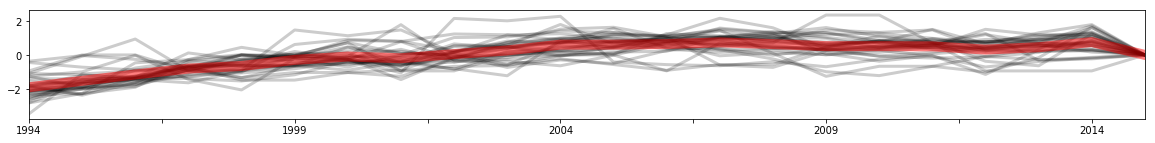

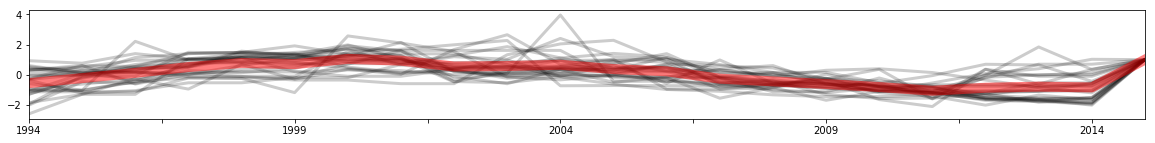

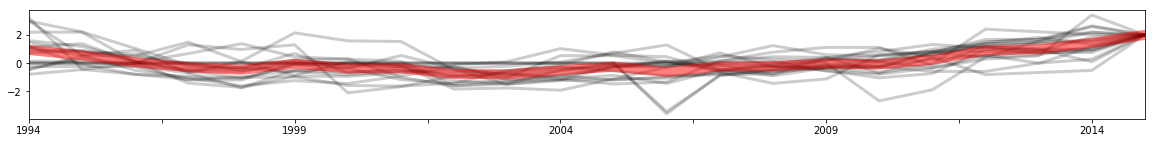

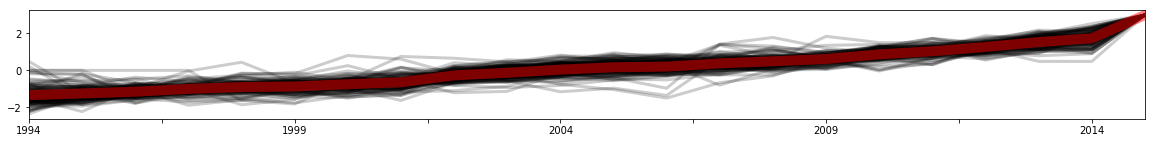

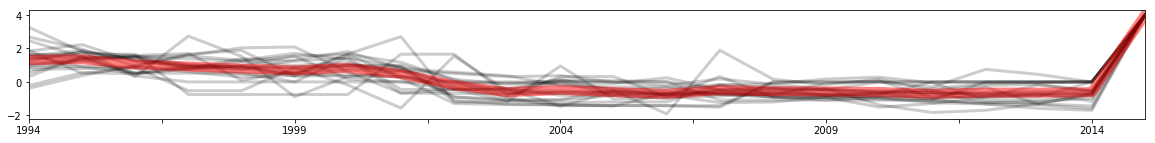

In [50]:
plt.figure(figsize(20,2), dpi=100)

for i in range(5):
    vals[vals.label==i].T.plot(legend=False, c='k', alpha=0.2, lw=3)
    vals[vals.label==i].mean().T.plot(linewidth=10, alpha=0.5, c='r')

**Figure 1:** The business pattern time series are plotted. each plot resembles a cluster of time series as produced by a K 5 means model

In [51]:
# taking only the zips and cluster labels 
vals_ = pd.DataFrame(vals.index, vals.label).reset_index()
vals_.zip = vals_.zip.astype(int)

In [52]:
vals_.head()

,label,zip
0,0,10001
1,3,10002
2,3,10003
3,3,10004
4,0,10005


In [53]:
# the zipcode column in the shapefile was a string
nyczipsshp.ZIPCODE = nyczipsshp.ZIPCODE.astype(int)
nyczipsshp.sort_values(by='ZIPCODE', axis=0, inplace=True)

In [54]:
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
54,83,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998309.7254775614 229616.6812362969,..."
82,10001,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
92,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."
90,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ..."
113,10004,0,New York,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.4500830621 188447.2783390433,..."


In [55]:
# merging the labels on the zipcodes
nyczipsshp_ = nyczipsshp.merge(vals_, right_on='zip', left_on='ZIPCODE', how='left')
nyczipsshp_.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,label,zip
0,83,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998309.7254775614 229616.6812362969,...",NaN,NaN
1,10001,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,...",0.0,10001.0
2,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,...",3.0,10002.0
3,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ...",3.0,10003.0
4,10004,0,New York,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.4500830621 188447.2783390433,...",3.0,10004.0


## Agglomerative clustering

In [56]:
vals.iloc[:, :-1].shape

(243, 21)

In [57]:
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals.iloc[:, :-1])
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))



In [58]:
labelsag

array([0, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 3, 0, 2, 3, 0, 3, 2, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 2, 0, 0, 4, 4, 2, 4,
       0, 4, 3, 2, 1, 3, 1, 1, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 3, 3, 0, 3, 3,
       4, 0, 4, 1, 2, 3, 3, 0, 4, 3, 3, 0, 4, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3,
       1, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [59]:
centroidsag

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [60]:
vals['label_2'] = labelsag
vals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,label,label_2
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0,0
10002.0,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,3,0
10003.0,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,3,0
10004.0,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3,0
10005.0,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,0,0


In [61]:
vals.label_2.unique()

array([0, 3, 2, 4, 1])

Recursively merges the pair of clusters that minimally increases a given linkage distance.
It produced 5 clusters plotted below

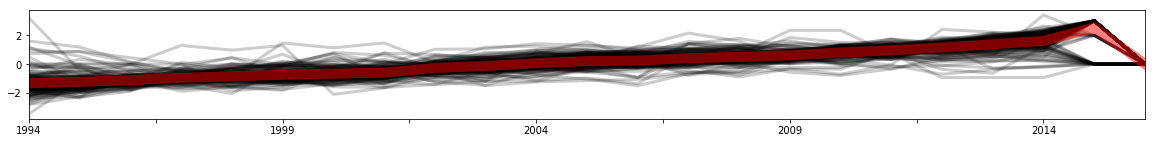

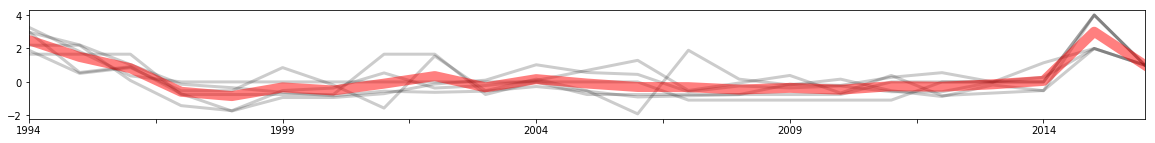

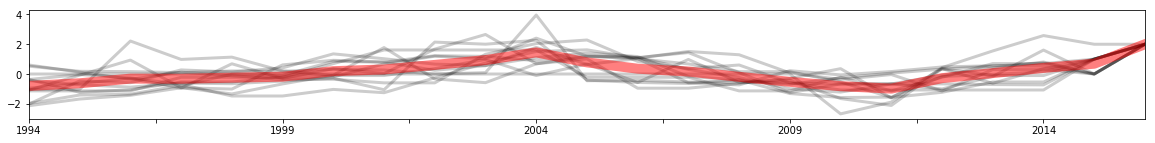

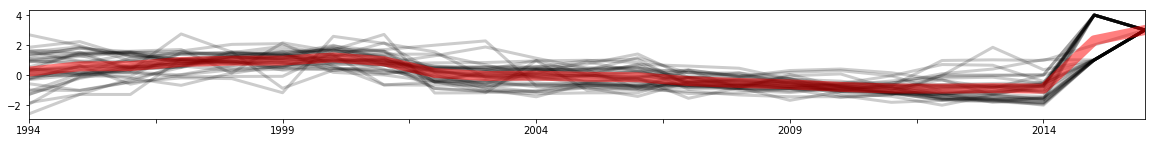

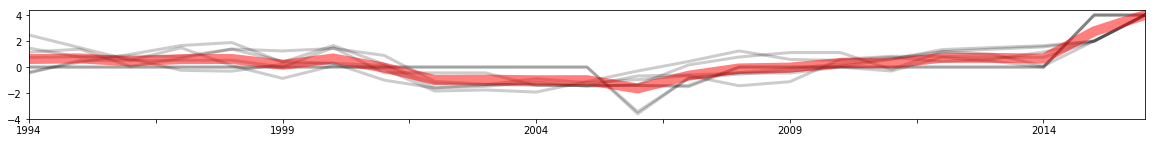

In [62]:
plt.figure(figsize(20,2), dpi=100)

for i in range(5):
    vals[vals.label_2==i].T.plot(legend=False, c='k', alpha=0.2, lw=3)
    vals[vals.label_2==i].mean().T.plot(linewidth=10, alpha=0.5, c='r')

**Figure 2:** The business pattern time series are plotted. each plot resembles a cluster of time series as produced by an agglomerative clustering model.

In [63]:
# taking only the zips and cluster labels 
vals__ = pd.DataFrame(vals.index, vals.label_2).reset_index()
vals__.zip = vals__.zip.astype(int)

In [64]:
vals__.head()

,label_2,zip
0,0,10001
1,0,10002
2,0,10003
3,0,10004
4,0,10005


In [65]:
# merging the labels on the zipcodes
nyczipsshp_ = nyczipsshp_.merge(vals__, right_on='zip', left_on='ZIPCODE', how='left')
nyczipsshp_.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,label,zip_x,label_2,zip_y
0,83,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998309.7254775614 229616.6812362969,...",NaN,NaN,NaN,NaN
1,10001,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,...",0.0,10001.0,0.0,10001.0
2,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,...",3.0,10002.0,0.0,10002.0
3,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ...",3.0,10003.0,0.0,10003.0
4,10004,0,New York,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.4500830621 188447.2783390433,...",3.0,10004.0,0.0,10004.0


(905410.75604293647,
 1075212.5382562787,
 112386.35181947275,
 280345.45402395498)

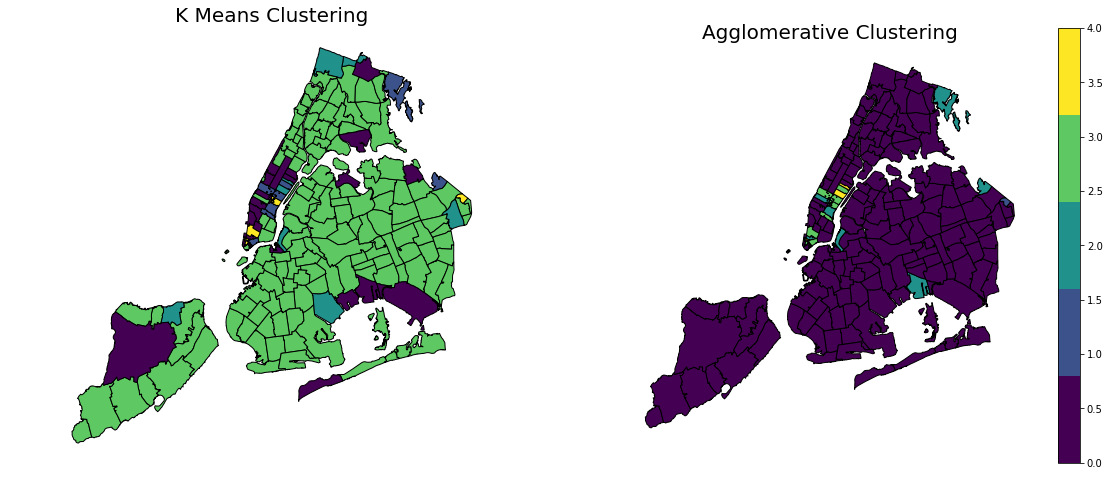

In [66]:
# plotting a choropleth colocoded according to the label
fig, ax = plt.subplots(1,2,figsize=(20,8))

nyczipsshp_.plot(ax=ax[0], column='label',cmap=plt.cm.get_cmap('viridis', 5), edgecolor='k', legend=True)
ax[0].set_title('K Means Clustering', fontsize=20)
ax[0].set_aspect('equal')
ax[0].axis('off')

nyczipsshp_.plot(ax=ax[1], column='label_2',cmap=plt.cm.get_cmap('viridis', 5), edgecolor='k', legend=False) 
ax[1].set_title('Agglomerative Clustering', fontsize=20)
ax[1].set_aspect('equal')
ax[1].axis('off')

# plt.colorbar(ticks=range(5), label='digit value')
# cbar = fig.colorbar(ax)
# cbar.ax.set_xticklabels(['1','2','3','4','5'])  # horizontal colorbar# 

# plt.legend(#scatterpoints=1, frameon=False, 
#     labelspacing=1, title='City Area')

#plt.colorbar(label='clusters')

**Figure 3:** the plots are for the city of new york. Each is a choropleth of cluster centers using clustering models, k-means clustering (left) and Agglomoritive clustering (right). The clustering is doen on the time stamps of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. Both models were set to cluster the data into five clusters. There is a great resemblence in the clusters produced yet it is not exactly the same. It is clear though that the models where distinguishing a pattern in midtown and lower Manhattan

### Hierarchical clustering in scipy: a dandrogram

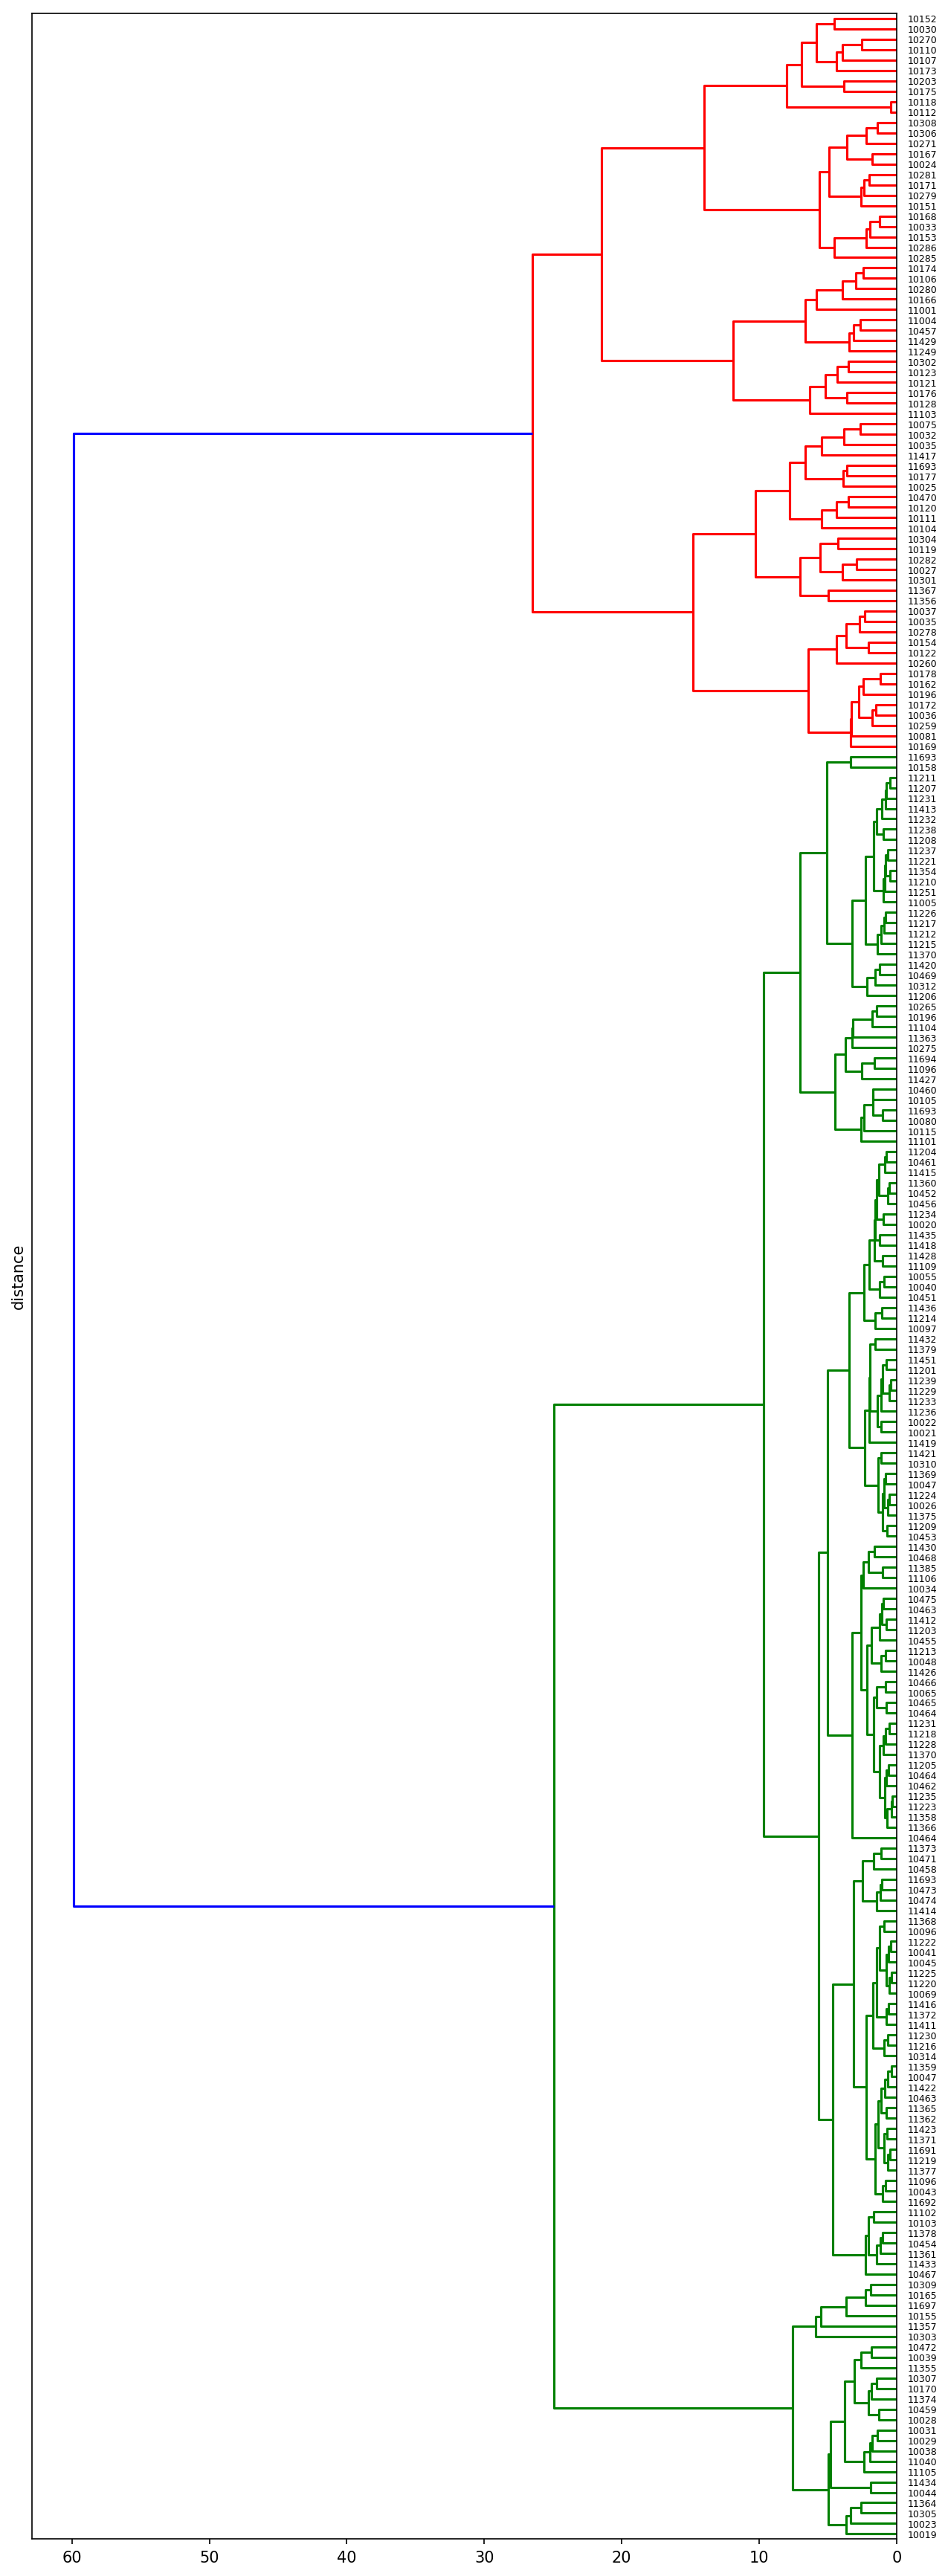

In [67]:
zipcodes = list(nyczipsshp_.ZIPCODE)

fig = plt.figure(figsize=(10,30), dpi=150)
plt.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = zipcodes,
                               #leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=6.,     # font size for the x axis labels)
                              orientation='left')
